In [1]:
"""
Based on the tutorial by
`Alexis Jacq <https://alexis-jacq.github.io>`
`Winston Herring <https://github.com/winston6>`_

"""

from __future__ import print_function
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import datetime

import zipfile
import time
import copy
import os
%matplotlib inline

In [7]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# def save(image, content, style, model):
#     ts = time.time()
#     filename = "output/" + model + "_" + content + "_" + style + "_" + \
#                datetime.datetime.fromtimestamp(ts).strftime('%Y_%m_%d_%H_%M_%S')+".jpg"
#     image = image.cpu().clone()  # we clone the tensor to not do changes on it
#     image = image.squeeze(0)  # remove the fake batch dimension
#     image = unloader(image)
#     image.save(filename)

def save(image, folder, number):
    ts = time.time()
    filename = folder + "/" + str(number) +".jpg"
    image = image.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    image.save(filename)

def gifify(folder):
    with imageio.get_writer(folder + '.gif', mode='I') as writer:
        for filename in os.listdir(folder):
            print(filename)
            if '.jpg' in filename:
                image = imageio.imread(folder + '/'+ filename)
                writer.append_data(image)

def zipdir(folder):
    # ziph is zipfile handle
    zipf = zipfile.ZipFile(folder + '/' + '.zip', 'w', zipfile.ZIP_DEFLATED)
    for root, dirs, files in os.walk(folder):
        for file in files:
            zipf.write(os.path.join(root, file))
    zipf.close()

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class ContentLoss(nn.Module):

    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input



class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers,
                               style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            name = 'adaptive'
        elif isinstance(layer, nn.Linear):
            name = 'linear'
        elif isinstance(layer, nn.Sequential):
            for block in layer.children():
                for sublayer in block.children():
                    if isinstance(sublayer, nn.Conv2d):
                        params = sublayer.extra_repr().split(', ')
                        i += 1
                        name = 'conv_{}'.format(i)
                        model.add_module(name, sublayer)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        if torch.cuda.is_available():
            model.cuda()

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps,
                       style_weight, content_weight,content_layers_default, style_layers_default,folder):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img,
                                                                     content_img, content_layers_default,
                                                                     style_layers_default)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            save(input_img, folder, run[0])
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score
            
        optimizer.step(closure)
    # a last correction...
    input_img.data.clamp_(0, 1)
#     zipdir(folder)

    return input_img

['conv_4']
['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


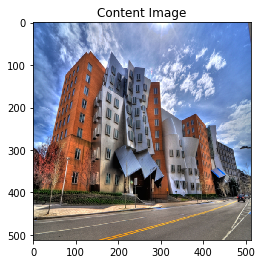

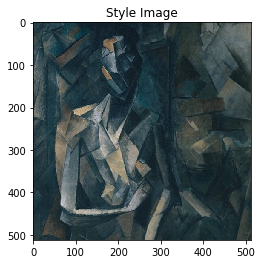

In [8]:
output_folder = "lowStyle2"
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
# Set the run variables
model = "vgg_19"
transfer_type = "static"
style_name = "picasso"
content_name = "building"
content_folder = "./jump/"
steps = 300  # Default 300
style_weight = 700000  # Default 1000000
content_weight = 1  # Default 1
save_output = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

style_img = image_loader("./" + style_name + ".jpg")
content_img = image_loader("./" + content_name + ".jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()

if model == "vgg_19":
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    content_layers_default = [4] # Default 4
    style_layers_default = [1,2,3,4,5] # Default 1,2,3,4,5
elif model == "vgg_16":
    cnn = models.vgg16(pretrained=True).features.to(device).eval()
    content_layers_default = [4] # Default 4
    style_layers_default = [1,2,3,4,5] # Default 1,2,3,4,5
elif model == "resnet_18":
    cnn = models.resnet18(pretrained=True)
    content_layers_default = [4,5,6,7,8] # Default 4,5,6,7,8
    # Need 6, 10, 14
    style_layers_default = [1,2,3,4,5,6,7] # Default 1,2,3,4,5,6,7

counter = 0
for layer in content_layers_default:
    content_layers_default[counter] = "conv_" + str(layer)
    counter += 1
counter = 0
for layer in style_layers_default:
    style_layers_default[counter] = "conv_" + str(layer)
    counter += 1
print(content_layers_default)
print(style_layers_default)

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

plt.figure()
imshow(content_img, title='Content Image')
plt.figure()
imshow(style_img, title='Style Image')

#     input_img = content_img.clone()
input_img = torch.randn(content_img.data.size(), device=device)

In [9]:
# add the original input image to the figure:
start_time = time.time()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, steps, style_weight, content_weight,
                            content_layers_default, style_layers_default,output_folder)

Building the style transfer model..


/home/liu.che/.conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/liu.che/.conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 58.197697 Content Loss: 20.268709

run [100]:
Style Loss : 17.920115 Content Loss: 14.141340

run [150]:
Style Loss : 4.076238 Content Loss: 10.443611

run [200]:
Style Loss : 1.780606 Content Loss: 8.129235

run [250]:
Style Loss : 1.275998 Content Loss: 6.824083

run [300]:
Style Loss : 1.016266 Content Loss: 6.120361



ELAPSED TIME
627.181166887


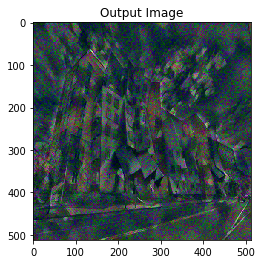

In [10]:
elapsed_time = time.time() - start_time
print("ELAPSED TIME")
print(elapsed_time)
if save_output:
    save(output, content_name, style_name, model)
plt.figure()
imshow(output, title='Output Image')


# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()